## OVA Kernel Perceptron

In this notebook, I generalise the perceptron algorithm to nonlinear multiclass classification. Nonlinear classification is achieved using the Polynomial or Gaussian kernel perceptron (tweak the main function to choose between the two), and multiclass classification using the OVA learning technique. Evaluation is done on the USPS dataset (7298 16x16 pixel images).

### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import time

### Load data

In [4]:
data = np.loadtxt('data.dat', dtype=float)

print("data shape:", data.shape)

data shape: (9298, 257)


### Functions

In [5]:
def train_test_split(data, train_size=0.8, random_state=None):
    """
    Splis dataset into training and test sets
    """
    m= len(data)
    m_train = int(train_size*m)
    idx = np.arange(m)
    
    if random_state:
        np.random.seed(random_state)
    
    # get indices for train and test data randomly
    train_idx = np.random.choice(a=idx, size=m_train, replace=False)
    test_idx = idx[np.isin(idx, train_idx,invert=True)]
    
    # split data
    data_train = data[train_idx]
    data_test = data[test_idx]
        
    return data_train, data_test, test_idx

In [6]:
def polynomial_kernel(X1, X2, degree:int =1):
    """
    Computes the polynomial kernel between X1 [nx1] and X2 [mx1]
        K(X1, X2) = <X1,X2>^degree        
    """        
    K = X1 @ X2.T
    K **= degree
    return K

In [7]:
def gaussian_kernel(X1, X2, c:int=1):
    """
    Computes the gaussian kernel between X1 and X2:
        K(x1, x2) = exp(-c ||x1-x2||^2)
    for each pair of rows x1 in X1 and x2 in X2
    """
    sqedist = cdist(X1, X2, 'sqeuclidean')
    K = np.exp(-c*sqedist)
    return K

In [8]:
def sign(y):
    """
    Returns sign of input variable to distinguish
    between positive and negative labels
    """
    if y <=0:
        return -1
    else:
        return 1

In [9]:
def train(y, weights, K):
    """
    Trains the Kernel perceptron algorithm using the
    OVA learning techninque
    """
    m, classes = weights.shape
    mistakes=0
    
    # loop through each instance
    for i in range(m):
        activations = predict(weights, K, i)
        
        # update weights for each hyperplane that made a mistake
        for c in range(classes): 
            # create transformed label z
            if c == y[i]: # if class=true label (y_t)
                z=1
            else:
                z=-1
            
            # activations[c] probability that y = c
            if z * activations[c] <= 0: # if mistake
                weights[i,c] -= sign(activations[c])
                # else no change
    return weights

In [10]:
def test(y, weights, K, C=None): 
    """
    Evaluates the perceptron algorithm on a test dataset
    """
    mistakes=0
    activations = weights.T @ K
    classes, m = activations.shape

    # if Confusion matrix given, calculate it (only in last epoch)
    if C is not None: 
        
        # loop through each instance (as online learning)
        for i in range(m):
            
            # predicted label is the one with the max activation
            y_hat = np.argmax(activations[:,i])
            
            # if mistake
            if y_hat != y[i]: 
                mistakes += 1
                
                C[int(y[i]), y_hat] +=1
                
                # keep track of mistakes in all epochs and last
                mistakes_all_epochs[true_test_idx[i]] += 1
                mistakes_last_epoch[true_test_idx[i]] += 1
                
        test_error = mistakes/m * 100
        return test_error, C
    
    else:
        # loop through each instance (as online learning)
        for i in range(m):
            
            # predicted label is the one with the max activation
            y_hat = np.argmax(activations[:,i])
            
            # if mistake
            if y_hat != y[i]: 
                mistakes += 1
                mistakes_all_epochs[true_test_idx[i]] += 1

        test_error = mistakes/m * 100
        return test_error

In [11]:
def predict(weight, K, idx):
    """
    Returns activation weights for all instances [10 x m]
    """
    return weight.T @ K[:, idx]

### Training

In [12]:
runs = 20
epochs = 20
k_folds = 5
d_array = np.arange(1,8)

d_stars_best = []
errors_test = []
Cs = [] # confusion matrices
mistakes_all_epochs = np.zeros(len(data))
mistakes_last_epoch = np.zeros(len(data))

for r in range(runs):
    
    print(f"****** run= {r+1} *******")
    
    # get random split 80%-20%
    data_train, data_test, true_test_idx = train_test_split(data)
    m_train = len(data_train)

    ######### TRAINING & TESTING USING d*=5 #########
    d_star=5
    K_train = polynomial_kernel(data_train[:,1:], data_train[:,1:],d_star)
    K_test = polynomial_kernel(data_train[:,1:], data_test[:,1:],d_star)
    
    C = np.zeros((10, 10)) #confusion matrix
    weights = np.zeros((m_train,10))
        
    for i in range(epochs):    
        weights = train(data_train[:,0], weights, K_train)
        error_test = test(data_test[:,0], weights, K_test)
        
        if i == epochs-1:
            error_test, C = test(data_test[:,0], weights, K_test, C)
    
    # store confusion matrix in each run
    Cs.append(C)
    
    # store final test error
    errors_test.append(error_test)    
    print(f"\ntest error for d_star: {error_test:.3f}\n")
    ##############################################
    

print(f"test error average: {np.mean(errors_test):.3f} std: {np.std(errors_test):.3f}")

****** run= 1 *******

test error for d_star: 2.312

****** run= 2 *******

test error for d_star: 2.742

****** run= 3 *******

test error for d_star: 2.527

****** run= 4 *******

test error for d_star: 2.796

****** run= 5 *******

test error for d_star: 3.226

****** run= 6 *******

test error for d_star: 2.581

****** run= 7 *******

test error for d_star: 2.903

****** run= 8 *******

test error for d_star: 2.527

****** run= 9 *******

test error for d_star: 2.742

****** run= 10 *******

test error for d_star: 3.065

****** run= 11 *******

test error for d_star: 2.957

****** run= 12 *******

test error for d_star: 2.903

****** run= 13 *******

test error for d_star: 2.312

****** run= 14 *******

test error for d_star: 2.903

****** run= 15 *******

test error for d_star: 2.742

****** run= 16 *******

test error for d_star: 2.419

****** run= 17 *******

test error for d_star: 3.172

****** run= 18 *******

test error for d_star: 1.935

****** run= 19 *******

test error fo

### Visualisation of results

#### Confusion matrix

In [13]:
# maximum number of mistakes
np.max(Cs)

6.0

In [14]:
# calculate mean and standard deviation
Cs_mean = np.mean(Cs, axis=0)
Cs_std = np.std(Cs, axis=0)

In [15]:
pd.DataFrame(Cs_mean)

,0,1,2,3,4,5,6,7,8,9
0,0.00,0.20,0.75,0.50,0.40,0.60,0.60,0.20,0.45,0.40
1,0.05,0.00,0.30,0.00,0.75,0.00,0.35,0.20,0.15,0.10
2,0.75,0.35,0.00,1.20,0.70,0.20,0.25,1.00,0.50,0.10
3,0.50,0.15,0.85,0.00,0.15,2.80,0.05,0.95,1.25,0.20
4,0.15,0.95,1.15,0.00,0.00,0.20,0.95,0.35,0.15,1.50
5,0.55,0.05,0.60,1.15,0.80,0.00,1.30,0.20,0.60,0.35
6,1.40,0.50,0.55,0.05,0.80,0.40,0.00,0.05,0.50,0.05
7,0.05,0.25,0.90,0.10,1.20,0.30,0.00,0.00,0.30,1.15
8,1.20,0.85,1.25,1.60,0.65,1.35,0.50,0.65,0.00,0.40
9,0.10,0.05,0.10,0.20,2.20,0.10,0.05,1.65,0.25,0.00


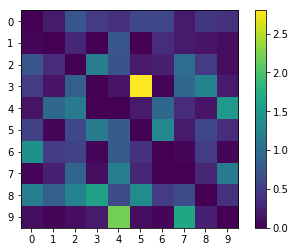

In [16]:
# display mean
plt.imshow(Cs_mean)

# format
plt.title('')
plt.colorbar()
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0,10))

In [17]:
pd.DataFrame(np.round(Cs_std,3))

,0,1,2,3,4,5,6,7,8,9
0,0.000,0.400,0.994,0.671,0.583,0.800,0.663,0.400,0.669,0.583
1,0.218,0.000,0.458,0.000,0.622,0.000,0.572,0.400,0.477,0.300
2,0.536,0.572,0.000,1.288,0.954,0.400,0.536,0.894,0.671,0.300
3,0.671,0.357,0.792,0.000,0.357,1.631,0.218,0.865,1.090,0.400
4,0.477,0.805,0.963,0.000,0.000,0.400,0.921,0.477,0.357,1.204
5,0.740,0.218,0.663,1.062,0.748,0.000,0.714,0.510,0.800,0.572
6,1.393,0.671,0.669,0.218,0.600,0.735,0.000,0.218,0.742,0.218
7,0.218,0.698,1.091,0.300,0.927,0.458,0.000,0.000,0.640,1.314
8,0.980,0.726,0.766,1.114,0.963,1.062,0.671,0.726,0.000,0.583
9,0.300,0.218,0.300,0.510,1.166,0.300,0.218,1.276,0.536,0.000


#### Hardest to predict digits

##### 20 epochs

In [18]:
worst2best_idx = np.argsort(mistakes_last_epoch)[::-1]
worst2best_idx

array([2167, 3637, 9105, ..., 6105, 6106,    0])

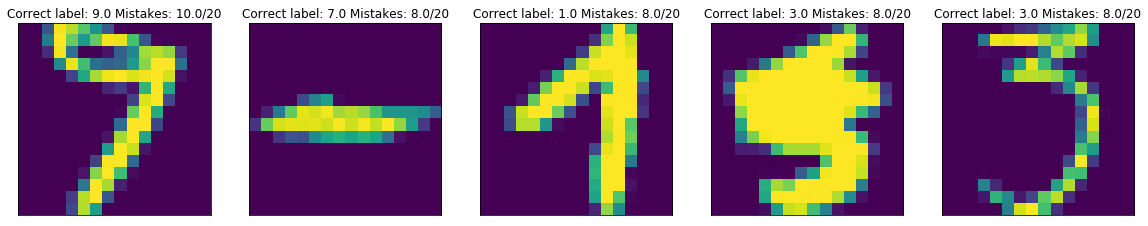

In [19]:
plt.figure(figsize=(20, 20))

# show 5 worst images
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # index of ith worst image
    worst_idx = worst2best_idx[i]
    
    # get ith worst image
    worst_image = data[worst_idx, 1:]
    worst_image = np.reshape(worst_image, (16, 16))
    
    # plot
    plt.imshow(worst_image)
    
    # format plot
    plt.title(f'Correct label: {data[worst_idx,0]} Mistakes: {mistakes_last_epoch[worst_idx]}/{runs}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

##### 50 epochs

In [20]:
runs = 50
epochs = 20
k_folds = 5
d_array = np.arange(1,8)

d_stars_best = []
errors_test = []
Cs = [] # confusion matrices
mistakes_all_epochs = np.zeros(len(data))
mistakes_last_epoch = np.zeros(len(data))

for r in range(runs):
    print(f"****** run= {r+1} *******")
    # get random split 80%-20%
    data_train, data_test, true_test_idx = train_test_split(data)
    m_train = len(data_train)

    ######### TRAINING & TESTING USING d*=5 #########
    d_star=5
    K_train = polynomial_kernel(data_train[:,1:], data_train[:,1:],d_star)
    K_test = polynomial_kernel(data_train[:,1:], data_test[:,1:],d_star)
    
    C = np.zeros((10, 10)) #confusion matrix
    weights = np.zeros((m_train,10))
        
    for i in range(epochs):    
        weights = train(data_train[:,0], weights, K_train)
        error_test = test(data_test[:,0], weights, K_test)
        
        if i == epochs-1:
            error_test, C = test(data_test[:,0], weights, 
                                            K_test, C)

    Cs.append(C)
    # store final test error
    errors_test.append(error_test)    
    print(f"\ntest error for d_star: {error_test:.3f}\n")
    ##############################################
    

print(f"test error average: {np.mean(errors_test):.3f} std: {np.std(errors_test):.3f}")

****** run= 1 *******

test error for d_star: 2.796

****** run= 2 *******

test error for d_star: 3.011

****** run= 3 *******

test error for d_star: 3.065

****** run= 4 *******

test error for d_star: 2.796

****** run= 5 *******

test error for d_star: 2.957

****** run= 6 *******

test error for d_star: 2.419

****** run= 7 *******

test error for d_star: 2.688

****** run= 8 *******

test error for d_star: 2.258

****** run= 9 *******

test error for d_star: 2.527

****** run= 10 *******

test error for d_star: 2.312

****** run= 11 *******

test error for d_star: 2.957

****** run= 12 *******

test error for d_star: 1.989

****** run= 13 *******

test error for d_star: 3.118

****** run= 14 *******

test error for d_star: 2.204

****** run= 15 *******

test error for d_star: 2.796

****** run= 16 *******

test error for d_star: 2.312

****** run= 17 *******

test error for d_star: 2.527

****** run= 18 *******

test error for d_star: 3.226

****** run= 19 *******

test error fo

In [21]:
worst2best_idx = np.argsort(mistakes_last_epoch)[::-1]
worst2best_idx

array([2670, 2999, 8607, ..., 6069, 6070,    0])

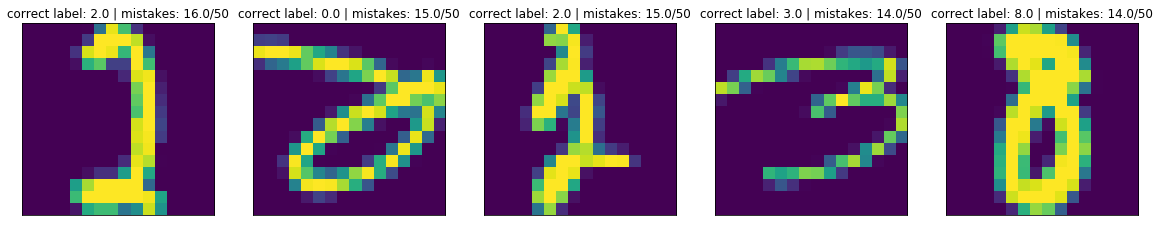

In [22]:
plt.figure(figsize=(20, 20))

# show 5 worst images
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # index of ith worst image
    worst_idx = worst2best_idx[i]
    
    # get ith worst image
    worst_image = data[worst_idx, 1:]
    worst_image = np.reshape(worst_image, (16, 16))
    
    # plot
    plt.imshow(worst_image)
    
    # format plot
    plt.title(f'correct label: {data[worst_idx,0]} | mistakes: {mistakes_last_epoch[worst_idx]}/{runs}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)